In [1]:
import sys

sys.path.append("..")

In [2]:
from pathlib import Path

import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

from src.model_manager import MLPManager
from src.loader import parse_out_data, parse_con_parameter
from src.preprocess import fill_nan_with_interp

In [3]:
def normalize(data):
    """
    Normalize the data to the range [0, 1].
    """
    data_min = np.min(data)
    data_max = np.max(data)
    return (data - data_min) / (data_max - data_min)

In [4]:
model_path = (
    Path("C:\\dev\\science\\xray_reflection\\XRRmaker\\models") / "mlp_model.pth"
)

npy_dir = Path(r"C:\dev\science\xray_reflection\data\processed")

if npy_dir.exists():
    print("npy 파일이 이미 존재합니다. 로드합니다.")
    X_data = np.load(npy_dir / "X_data.npy")
    y_data = np.load(npy_dir / "y_data.npy")
else:
    data_path = Path(r"C:\dev\science\xray_reflection\data\onelayer")

    X_data = []
    y_data = []
    for num in tqdm(range(1, 100001), desc="Load"):
        out_file = data_path / f"d{num:05}" / "1.out"
        con_file = data_path / f"d{num:05}" / "1.con"
        data = parse_out_data(out_file)
        x = data[["XOBS", "YCALC"]].values
        x = fill_nan_with_interp(x)
        X_data.append(x)
        y = np.asarray(parse_con_parameter(con_file))
        y_data.append(y)

    X_data = np.stack(X_data, axis=0)
    y_data = np.stack(y_data, axis=0)

    print('X data shape:', X_data.shape)
    print('y data shape:', y_data.shape)

    # npy로 저장

    npy_dir.mkdir(parents=True, exist_ok=True)

    np.save(npy_dir / "X_data.npy", X_data)
    np.save(npy_dir / "y_data.npy", y_data)

    print("데이터가 npy 파일로 저장되었습니다.")

npy 파일이 이미 존재합니다. 로드합니다.


In [11]:
# Preprocess the data

X_data = np.log(X_data + 1e-10)
y_data = np.log(y_data + 1e-10)

X_data = normalize(X_data)
y_data = normalize(y_data)[..., -4:]

In [12]:
# 테스트 데이터셋 비율 설정
test_size = 0.2

# 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=test_size, random_state=42, shuffle=True
)

# 나누어진 데이터셋 형상 확인
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (80000, 314, 2), y_train shape: (80000, 4)
X_test shape: (20000, 314, 2), y_test shape: (20000, 4)


In [13]:
input_dim: int = X_data.shape[1] * X_data.shape[2]
output_dim: int = y_data.shape[1]
manager = MLPManager(input_dim=input_dim, output_dim=output_dim, learning_rate=1e-5)

print('input_dim:', input_dim)
print('output_dim:', output_dim)

Initialized MLPManager on device: cpu
input_dim: 628
output_dim: 4


In [ ]:
history = manager.train(
    X_data=X_data,
    y_data=y_data,
    model_path=model_path,
    epochs=50,
    batch_size=64,
    val_ratio=0.1,
)

Epoch 1/25 - Train Loss: 0.0305 - Val Loss: 350047097.2416
Epoch 2/25 - Train Loss: 0.0299 - Val Loss: 879982464.2048


KeyboardInterrupt: 

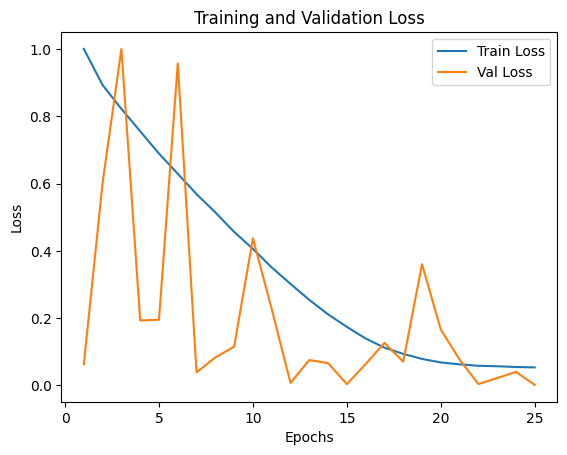

In [ ]:
epochs = range(1, len(history["train_loss"]) + 1)
plt.plot(epochs, np.array(history["train_loss"]) / max(history["train_loss"]), label="Train Loss")
plt.plot(epochs, np.array(history["val_loss"]) / max(history["val_loss"]), label="Val Loss")
plt.title("Training and Validation Loss (Normalized)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

In [9]:
predictions = manager.predict(X_test, model_path=model_path)

print("Predictions Shape:", predictions.shape)

Model state loaded from C:\dev\science\xray_reflection\XRRmaker\models\mlp_model.pth
Predictions Shape: (20000, 4)


In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 모델 평가
# 평균 제곱 오차 (MSE) 계산
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error (MSE): {mse:.4f}")

# 평균 절대 오차 (MAE) 계산
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

output_dim_indices = list(range(y_data.shape[1]))
for i, idx in enumerate(output_dim_indices):
    mse_single = mean_squared_error(y_test[:, i], predictions[:, i])
    mae_single = mean_absolute_error(y_test[:, i], predictions[:, i])
    print(f"Output Dim {idx} - MSE: {mse_single:.4f}, MAE: {mae_single:.4f}")

Mean Squared Error (MSE): 1180645958.8973
Mean Absolute Error (MAE): 28951.9618
Output Dim 0 - MSE: 1157760.0922, MAE: 1075.9926
Output Dim 1 - MSE: 2822731224.3834, MAE: 53129.3819
Output Dim 2 - MSE: 900402856.0296, MAE: 30006.7135
Output Dim 3 - MSE: 998291995.0839, MAE: 31595.7591
